# Predizione del prezzo di un volo aereo

**Progetto di Programmazione di Applicazioni Data Intensive - 2022/2023**  
Ingegneria e Scienze Informatiche  
Università di Bologna, Cesena

Silvia Furegato - 977475  
silvia.furegato@studio.unibo.it

---
## Obiettivo
L'obbiettivo di questo progetto è quello di predire il prezzo di un volo in base alle sue caratteristiche.

---
## Importazione delle librerie
Per prima cosa importiamo alcune delle librerie che utilizzeremo per gestire ed analizzare il dataset.

In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

---
## Caricamento ed analisi dei dati
Cominciamo caricando un dataset sui voli ottenuto da [Kaggle](https://www.kaggle.com/datasets/shubhambathwal/flight-price-prediction) ed analizziamone la struttura.

In [36]:
import os.path as os

file = "Flight_Prices.csv";

if not os.exists(file):
    print("Missing dataset!");

dataset = pd.read_csv(file, index_col=0)

In [37]:
dataset.head(3)

,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
0,SpiceJet,SG-8709,Delhi,Evening,zero,Night,Mumbai,Economy,2.17,1,5953
1,SpiceJet,SG-8157,Delhi,Early_Morning,zero,Morning,Mumbai,Economy,2.33,1,5953
2,AirAsia,I5-764,Delhi,Early_Morning,zero,Early_Morning,Mumbai,Economy,2.17,1,5956


In [38]:
dataset.tail(3)

,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
300150,Vistara,UK-832,Chennai,Early_Morning,one,Night,Hyderabad,Business,13.83,49,79099
300151,Vistara,UK-828,Chennai,Early_Morning,one,Evening,Hyderabad,Business,10.00,49,81585
300152,Vistara,UK-822,Chennai,Morning,one,Evening,Hyderabad,Business,10.08,49,81585


In [39]:
dataset.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 300153 entries, 0 to 300152
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   airline           300153 non-null  object 
 1   flight            300153 non-null  object 
 2   source_city       300153 non-null  object 
 3   departure_time    300153 non-null  object 
 4   stops             300153 non-null  object 
 5   arrival_time      300153 non-null  object 
 6   destination_city  300153 non-null  object 
 7   class             300153 non-null  object 
 8   duration          300153 non-null  float64
 9   days_left         300153 non-null  int64  
 10  price             300153 non-null  int64  
dtypes: float64(1), int64(2), object(8)
memory usage: 155.1 MB


Vediamo che non sono presenti valori nulli.  
Inoltre osserviamo che nel dataset sono presenti 300153 voli. Decidiamo quindi di ridurre le dimesioni del dataset per velocizzare l'addestramento dei modelli.

In [40]:
dataset = dataset.sample(n = 100000, random_state = 11)
dataset.info(verbose=False, memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 145718 to 94011
Columns: 11 entries, airline to price
dtypes: float64(1), int64(2), object(8)
memory usage: 51.7 MB


### Significato delle colonne

Nel dataset sono presenti 11 colonne:  

- `Airline`: Il nome della compagnia aerea. Nel dataset sono presenti sei compagnie diverse.  
- `Flight`: Il codice di volo dell'aereo.  
- `Source City`: Città di partenza. Sono presenti sei città diverse.  
- `Departure Time`: Momento della giornata in cui l'aereo è partito. Anche per questo campo ci sono sei valori differenti.  
- `Stops`: Numero di scali. Ci sono tre valori possibili per questo campo.  
- `Arrival Time`: Momento della giornata in cui l'aereo giunge a destinazione.  
- `Destination City`: Città di arrivo.  
- `Class`: Classe del volo. Ha due valori: Business ed Economy.  
- `Duration`: Tempo di volo in ore.  
- `Days Left`: Quanti giorni prima del volo è stato acquistato il biglietto aereo.  
- `Price`: Prezzo del biglietto.  

La variabile che cercheremo di predire è `Price`.

Il codice del volo (`flight`) non è significativo, in quanto dipende dalla compagnia aerea e dalle città di partenza ed arrivo quindi lo elimineremo. Inoltre il campo `Arrival Time` può essere facilmente desunto da `Departure time` e `Duration`, quindi elimineremo anche quello.

In [41]:
dataset = dataset.drop(columns=["flight", "arrival_time"])
dataset.head(2)

,airline,source_city,departure_time,stops,destination_city,class,duration,days_left,price
145718,AirAsia,Kolkata,Evening,two_or_more,Hyderabad,Economy,13.00,30,4589
104513,AirAsia,Bangalore,Early_Morning,one,Kolkata,Economy,13.33,15,5176


Sono presenti molte colonne di tipo object, trasformiamole in tipo categorico.

In [42]:
categorical_fields = ["airline", "source_city", "departure_time", "stops", "destination_city", "class"];

for field in categorical_fields:
    dataset[field] = dataset[field].astype("category")

In [43]:
dataset.dtypes

airline             category
source_city         category
departure_time      category
stops               category
destination_city    category
class               category
duration             float64
days_left              int64
price                  int64
dtype: object

In [44]:
dataset.info(verbose=False, memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 145718 to 94011
Columns: 9 entries, airline to price
dtypes: category(6), float64(1), int64(2)
memory usage: 3.6 MB


Come possiamo vedere, l'utilizzo di memoria è diminuito drasticamente.  
Vediamo ora alcune statistiche sui campi numerici.

In [45]:
dataset.describe()

,duration,days_left,price
count,100000.000000,100000.000000,100000.000000
mean,12.217848,26.054860,20969.254290
std,7.194303,13.573797,22758.422346
min,0.830000,1.000000,1105.000000
25%,6.750000,15.000000,4784.000000
50%,11.250000,26.000000,7426.000000
75%,16.170000,38.000000,42521.000000
max,47.750000,49.000000,114705.000000


Contiamo quanti valori diversi abbiamo per ciascun campo categorico.

In [46]:
for field in categorical_fields:
    print(f"{field}: {len(dataset[field].unique())}")

airline: 6
source_city: 6
departure_time: 6
stops: 3
destination_city: 6
class: 2


### Analisi esplorativa

Ora osserviamo le distribuzioni dei valori delle variabili categoriche.

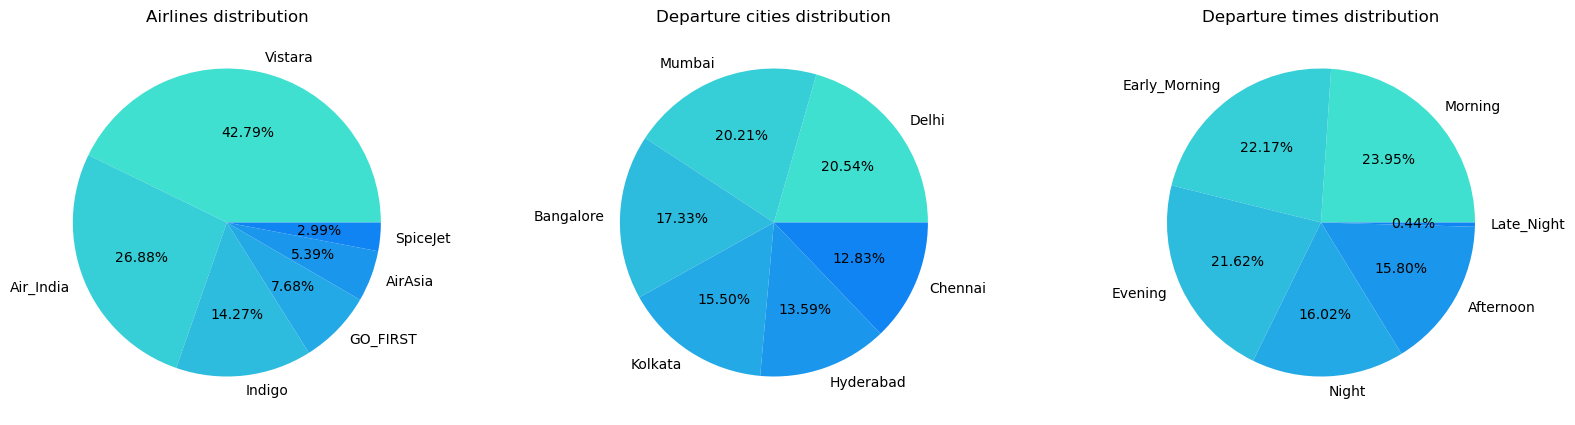

In [47]:
colors = ["#40e0d0", "#36ced7", "#2dbbde", "#23a9e5", "#1a97ec", "#1084f3"]

airline_values = dataset["airline"].value_counts()
dep_city_values = dataset["source_city"].value_counts()
time_values = dataset["departure_time"].value_counts()

plt.figure(figsize=(20, 5))

plt.subplot(1, 3, 1).pie(airline_values, labels = airline_values.index, autopct='%2.2f%%', colors = colors)
plt.title('Airlines distribution');

plt.subplot(1, 3, 2).pie(dep_city_values, labels = dep_city_values.index, autopct='%2.2f%%', colors = colors)
plt.title('Departure cities distribution');

plt.subplot(1, 3, 3).pie(time_values, labels = time_values.index, autopct='%2.2f%%', colors = colors)
plt.title('Departure times distribution');

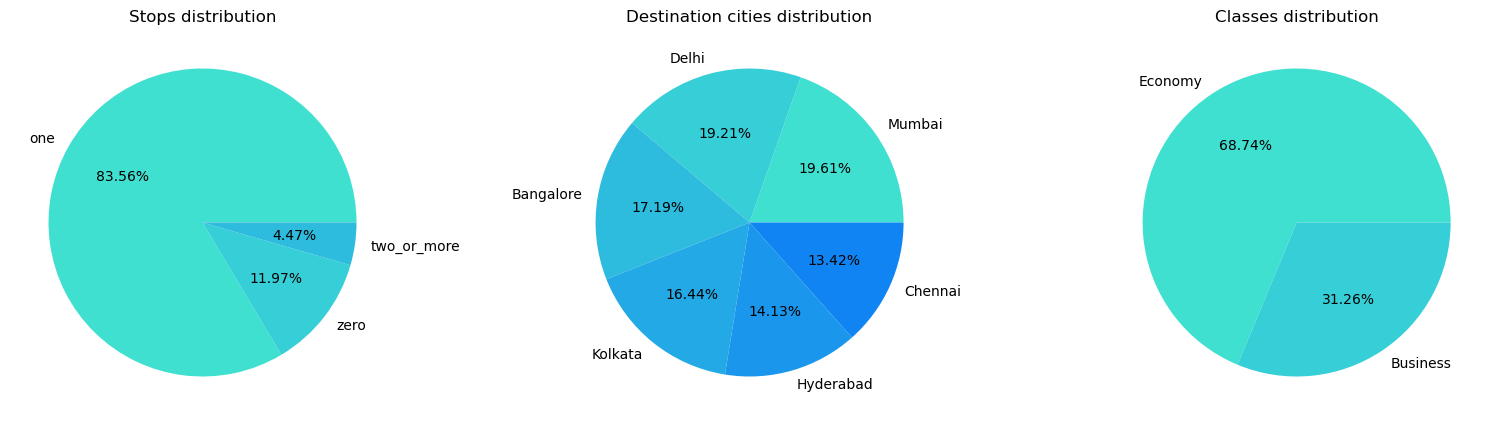

In [48]:
stops_values = dataset["stops"].value_counts()
dest_city_values = dataset["destination_city"].value_counts()
class_values = dataset["class"].value_counts()

plt.figure(figsize=(20, 5))

plt.subplot(1, 3, 1).pie(stops_values, labels = stops_values.index, autopct='%2.2f%%', colors = colors)
plt.title('Stops distribution');

plt.subplot(1, 3, 2).pie(dest_city_values, labels = dest_city_values.index, autopct='%2.2f%%', colors = colors)
plt.title('Destination cities distribution');

plt.subplot(1, 3, 3).pie(class_values, labels = class_values.index, autopct='%2.2f%%', colors = colors)
plt.title('Classes distribution');

Confrontiamo il prezzo dei biglietti medio per ciascuna compagnia aerea.

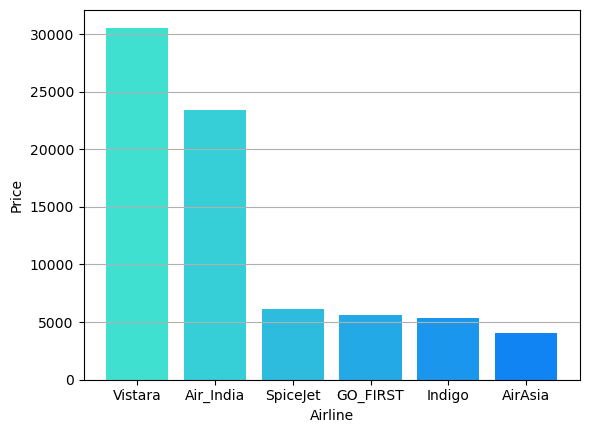

In [49]:
airline_price = dataset.groupby("airline")["price"].mean().sort_values(ascending = False).reset_index()

plt.bar(airline_price["airline"], airline_price["price"], color = colors)
plt.xlabel("Airline")
plt.ylabel("Price")
plt.grid(axis='y')
plt.show()

Come possiamo vedere, la compagnia aerea con i prezzi più alti è Vistara, seguita da Air India, le altre compagnie hanno invece prezzi più contenuti.  
Guardiamo ora la relazione fra città di partenza ed arrivo, durata del volo e prezzo.

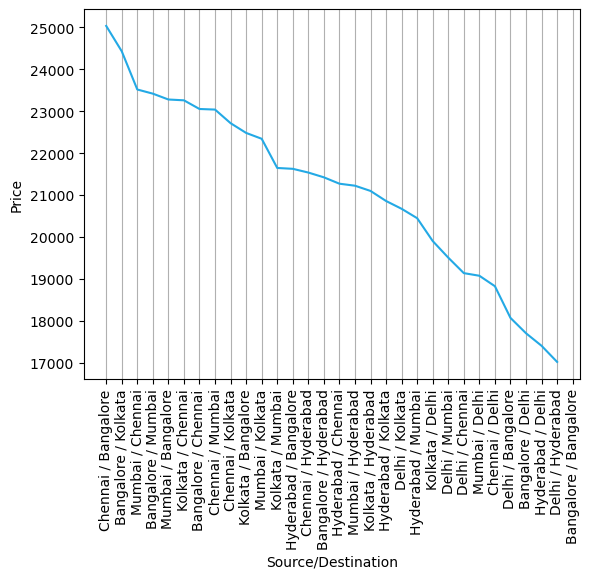

In [51]:
source_destination_price = dataset.groupby(['source_city','destination_city'])['price'].mean()\
.sort_values(ascending=False).reset_index()
source_destination_price["s/d"] = source_destination_price[['source_city', 'destination_city']].agg(' / '.join, axis=1)
source_destination_price.drop(columns=['source_city','destination_city'], inplace = True)

plt.plot(source_destination_price["s/d"], source_destination_price["price"], color = colors[3])
plt.xticks(rotation='vertical')
plt.xlabel("Source/Destination")
plt.ylabel("Price")
plt.grid(axis='x')
plt.show()

I voli più costosi sono quelli che vanno da Chennai a Bangalore.  
Passiamo alla durata media dei voli.

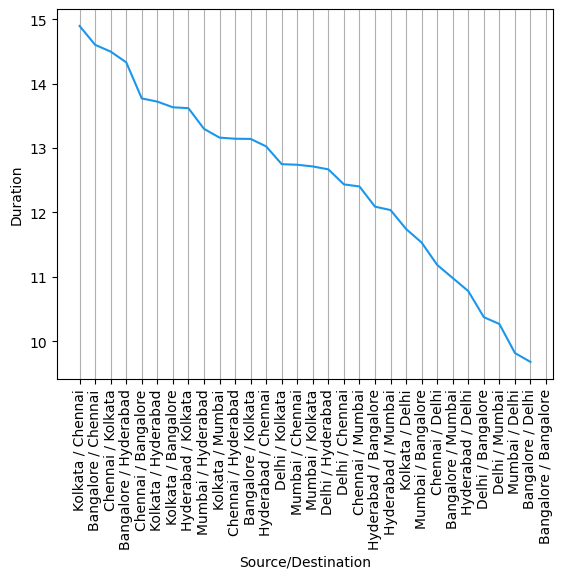

In [52]:
source_destination_duration = dataset.groupby(['source_city','destination_city'])['duration'].mean()\
.sort_values(ascending=False).reset_index()
source_destination_duration["s/d"] = source_destination_duration[['source_city', 'destination_city']].agg(' / '.join, axis=1)
source_destination_duration.drop(columns=['source_city','destination_city'], inplace = True)

plt.plot(source_destination_duration["s/d"], source_destination_duration["duration"], color = colors[4])
plt.xticks(rotation='vertical')
plt.xlabel("Source/Destination")
plt.ylabel("Duration")
plt.grid(axis='x')
plt.show()

La distanza più lunga da percorrere è Kolkata/Chennai, inoltre vediamo che la coppia Bangalore/Chennai rimane comunque fra le tratte più lunghe da percorrere, questo potrebbe giustificarne il prezzo che abbiamo trovato precedentemente.  
Osserviamo ora la relazione fra prezzi e orario di partenza.

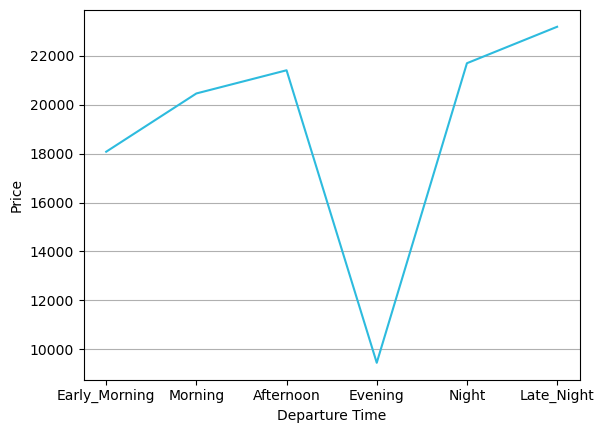

In [53]:
departures_price = dataset.groupby(["departure_time"])["price"].mean().reset_index()
times = ["Early_Morning", "Morning", "Afternoon", "Evening", "Night", "Late_Night"]

plt.plot(times, departures_price["price"], color = colors[2])
plt.xlabel("Departure Time")
plt.ylabel("Price")
plt.grid(axis='y')
plt.show()

Vediamo che per i voli che partono la sera i prezzi sono molto più bassi rispetto alle altre fasce orarie.  
Cerchiamo ora di capire se il numero di scali influisce sul prezzo.

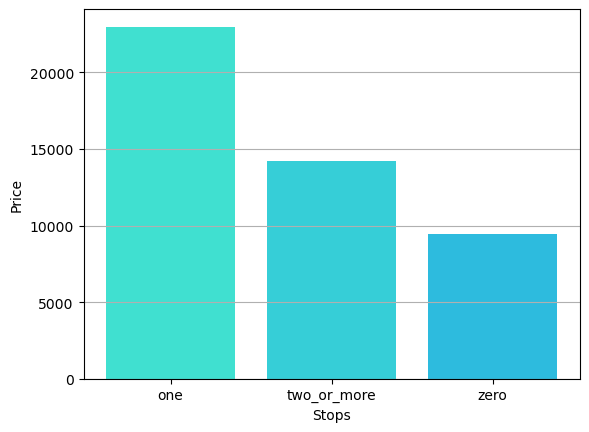

In [54]:
stops_price = dataset.groupby('stops')['price'].mean().reset_index()

plt.bar(stops_price['stops'], stops_price["price"], color = colors)
plt.xlabel("Stops")
plt.ylabel("Price")
plt.grid(axis='y')
plt.show()

Per quanto riguarda gli scali, possiamo vedere che i voli più costosi, in media, sono quelli che fanno uno scalo.  
Osserviamo la distribuzione dei prezzi rispetto alla classe in cui si vola.

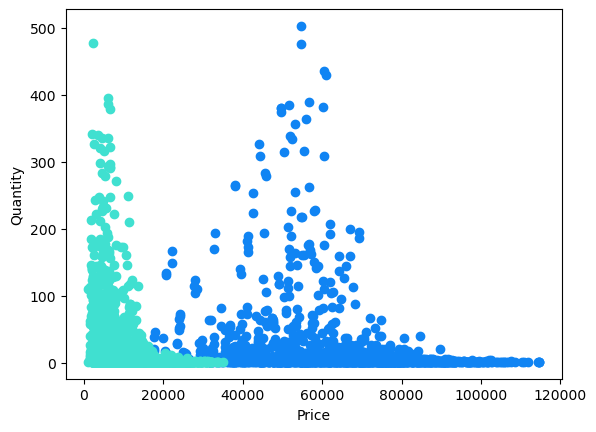

There are 31255 business tickets and 68745 economy tickets.


In [55]:
business_tickets = dataset[dataset["class"] == "Business"]
economy_tickets = dataset[dataset["class"] == "Economy"]

business_price = business_tickets["price"].reset_index().drop(columns=["index"])
business_occurrence = business_price.value_counts().reset_index()
business_occurrence.rename(columns={business_occurrence.columns[1]: "occurrence"}, inplace = True)
business_occurrence["price"].sort_values(ascending = False)

economy_price = economy_tickets["price"].reset_index().drop(columns=["index"])
economy_occurrence = economy_price.value_counts().reset_index()
economy_occurrence.rename(columns={economy_occurrence.columns[1]: "occurrence"}, inplace = True)
economy_occurrence["price"].sort_values(ascending = False)

plt.scatter(business_occurrence["price"], business_occurrence["occurrence"], color=colors[5])
plt.scatter(economy_occurrence["price"], economy_occurrence["occurrence"], color=colors[0])
plt.xlabel("Price")
plt.ylabel("Quantity")
plt.show()

print(f"There are {len(business_tickets)} business tickets and {len(economy_tickets)} economy tickets.")

Possiamo notare che i voli in economy sono distribuiti in una fascia di prezzo più bassa rispetto a quelli in business, inoltre sono stati acquistati molti più biglietti della classe economy rispetto alla business.

Osserviamo ora come cambiano i prezzi rispetto a quanti giorni prima viene acquistato il biglietto.

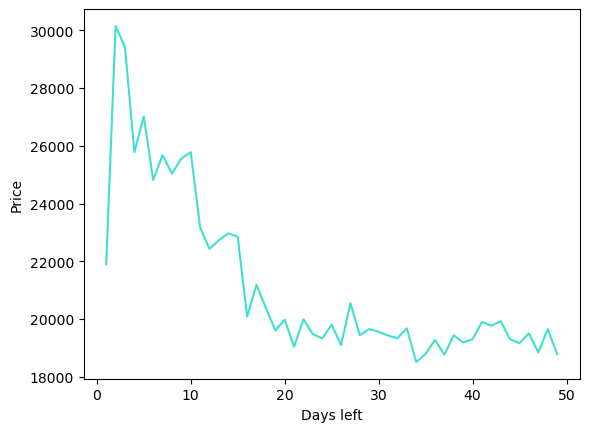

In [56]:
days_price = dataset.groupby(['days_left'])['price'].mean().reset_index()

plt.plot(days_price["days_left"], days_price["price"], color = colors[0])
plt.xlabel("Days left")
plt.ylabel("Price")
plt.show()

Possiamo vedere che i prezzi dei bliglietti acquistati pochi giorni prima della partenza sono molto più alti di quelli acquistati più di 20 giorni prima.

---
## Preparazione dei dati

In [57]:
# Import delle librerie necessarie
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

Dividiamo il dataset in training set e test set.

In [58]:
x = dataset.drop(columns="price")
y = dataset["price"]

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.4, random_state = 11)

Avevamo precedentemente raccolto le variabili categoriche in una lista, raccogliamo anche quelle numeriche così da poter applicare un preprocessing personalizzato per ciascuna tipologia di dato.

In [59]:
numeric_fields = ["duration", "days_left"]

Definiamo anche una funzione che ci permetta di valutare l'accuratezza dei modelli.

In [60]:
def relative_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true))


def print_eval(X, y, model):
    preds = model.predict(X)
    mse = mean_squared_error(y, preds)
    re = relative_error(y, preds)
    r2 = r2_score(y, preds)
    print(f"   Mean squared error: {mse:.5}")
    print(f"       Relative error: {re:.5%}")
    print(f"R-squared coefficient: {r2:.5}")

---
### Addestramento dei modelli

Procederemo testando diversi tipi di modello, cercando quello che avrà un'accuratezza maggiore nel predire i prezzi dei voli.  
In particolare utilizzeremo:  
- Regressione lineare
- Regressione ridge
- Regressione lasso
- Regressione elastic net
- Decision Tree Regression
- XGBoost Regressor

In [61]:
# Import librerie necessarie
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor

kf = KFold(5, shuffle=True, random_state=42)

**Regressione Lineare**  
Cominciamo con una semplice regressione lineare. Per tutti i modelli ricercheremo gli iperparametri migliori tramite gridsearch con k-fold cross validation.

In [83]:
preprocessor = ColumnTransformer([
    ("categorical", OneHotEncoder() , categorical_fields),
    ("numeric", StandardScaler(), numeric_fields)
])

linreg = Pipeline([
    ("preproc", preprocessor),
    ("regr"   , LinearRegression())
])

grid = {
    "preproc__numeric": ["passthrough", StandardScaler()],
}

linear_gs = GridSearchCV(linreg, grid, cv=kf)
linear_gs.fit(x_train, y_train);

print("TRAINING SET:")
print_eval(x_train, y_train, linear_gs)
print("----------------------------------")
print("VALIDATION SET:")
print_eval(x_val, y_val, linear_gs)

print(f"\nBest iperparameters: {linear_gs.best_params_}")

TRAINING SET:
   Mean squared error: 4.5686e+07
       Relative error: 46.35300%
R-squared coefficient: 0.91144
----------------------------------
VALIDATION SET:
   Mean squared error: 4.6649e+07
       Relative error: 46.86878%
R-squared coefficient: 0.91047

Best iperparameters: {'preproc__numeric': 'passthrough'}


Ora proviamo valutare per la regressione anche termini di grado superiore al primo.

In [63]:
preprocessor = ColumnTransformer([
    ("categorical", OneHotEncoder() , categorical_fields),
    ("poly", PolynomialFeatures(include_bias=False), numeric_fields),
    ("numeric", StandardScaler(), numeric_fields)
])

polyreg = Pipeline([
    ("preproc", preprocessor),
    ("regr"   , LinearRegression())
])

grid = {
    "preproc__numeric": ["passthrough", StandardScaler()],
    "preproc__poly__degree": [2, 3],
}

poly_gs = GridSearchCV(polyreg, grid, cv=kf)
poly_gs.fit(x_train, y_train);

print("TRAINING SET:")
print_eval(x_train, y_train, poly_gs)
print("----------------------------------")
print("VALIDATION SET:")
print_eval(x_val, y_val, poly_gs)

print(f"\nBest iperparameters: {poly_gs.best_params_}")

TRAINING SET:
   Mean squared error: 4.3725e+07
       Relative error: 44.99298%
R-squared coefficient: 0.91524
----------------------------------
VALIDATION SET:
   Mean squared error: 4.4551e+07
       Relative error: 45.50010%
R-squared coefficient: 0.9145

Best iperparameters: {'preproc__numeric': 'passthrough', 'preproc__poly__degree': 3}


Il risultato è leggermente migliore del primo, ma comunque ha un errore relativo ancora piuttosto alto.

**Regressione Ridge**

In [64]:
preprocessor = ColumnTransformer([
    ("categorical", OneHotEncoder() , categorical_fields),
    ("poly", PolynomialFeatures(include_bias=False), numeric_fields),
    ("numeric", StandardScaler(), numeric_fields)
])

ridgereg = Pipeline([
    ("preproc", preprocessor),
    ("regr"   , Ridge())
])

grid = {
    "preproc__numeric": ["passthrough", StandardScaler()],
    "preproc__poly__degree": [1, 2, 3],
    "regr__alpha": [0.1, 1, 10]
}

ridge_gs = GridSearchCV(ridgereg, grid, cv=kf)
ridge_gs.fit(x_train, y_train);

print("TRAINING SET:")
print_eval(x_train, y_train, ridge_gs)
print("----------------------------------")
print("VALIDATION SET:")
print_eval(x_val, y_val, ridge_gs)

print(f"\nBest iperparameters: {ridge_gs.best_params_}")

TRAINING SET:
   Mean squared error: 4.3725e+07
       Relative error: 44.99185%
R-squared coefficient: 0.91524
----------------------------------
VALIDATION SET:
   Mean squared error: 4.4551e+07
       Relative error: 45.49880%
R-squared coefficient: 0.9145

Best iperparameters: {'preproc__numeric': StandardScaler(), 'preproc__poly__degree': 3, 'regr__alpha': 1}


Anche applicando un modello con una regolarizzazione L2 i risultati non sembrano migliori.

**Regressione Lasso**

In [65]:
preprocessor = ColumnTransformer([
    ("categorical", OneHotEncoder() , categorical_fields),
    ("numeric", StandardScaler(), numeric_fields)
])

lassoreg = Pipeline([
    ("preproc", preprocessor),
    ("regr"   , Lasso())
])

grid = {
    "preproc__numeric": ["passthrough", StandardScaler()],
    "regr__alpha": [0.1, 1, 10]
}

lasso_gs = GridSearchCV(lassoreg, grid, cv=kf)
lasso_gs.fit(x_train, y_train);

print("TRAINING SET:")
print_eval(x_train, y_train, lasso_gs)
print("----------------------------------")
print("VALIDATION SET:")
print_eval(x_val, y_val, lasso_gs)

print(f"\nBest iperparameters: {lasso_gs.best_params_}")

TRAINING SET:
   Mean squared error: 4.5686e+07
       Relative error: 46.34914%
R-squared coefficient: 0.91144
----------------------------------
VALIDATION SET:
   Mean squared error: 4.6649e+07
       Relative error: 46.86450%
R-squared coefficient: 0.91047

Best iperparameters: {'preproc__numeric': 'passthrough', 'regr__alpha': 0.1}


**Regressione Elastic Net**

In [66]:
preprocessor = ColumnTransformer([
    ("categorical", OneHotEncoder() , categorical_fields),
    ("numeric", StandardScaler(), numeric_fields)
])

elasticreg = Pipeline([
    ("preproc", preprocessor),
    ("regr"   , ElasticNet())
])

grid = {
    "preproc__numeric": ["passthrough", StandardScaler()],
    "regr__alpha": [0.1, 1, 10],
    "regr__l1_ratio": [0.2, 0.5, 0.8]
}

elastic_gs = GridSearchCV(elasticreg, grid, cv=kf)
elastic_gs.fit(x_train, y_train);

print("TRAINING SET:")
print_eval(x_train, y_train, elastic_gs)
print("----------------------------------")
print("VALIDATION SET:")
print_eval(x_val, y_val, elastic_gs)

print(f"\nBest iperparameters: {elastic_gs.best_params_}")

TRAINING SET:
   Mean squared error: 4.6941e+07
       Relative error: 44.99848%
R-squared coefficient: 0.909
----------------------------------
VALIDATION SET:
   Mean squared error: 4.7942e+07
       Relative error: 45.35493%
R-squared coefficient: 0.90799

Best iperparameters: {'preproc__numeric': StandardScaler(), 'regr__alpha': 0.1, 'regr__l1_ratio': 0.8}


**Regressione con Decision Tree**

In [67]:
preprocessor = ColumnTransformer([
    ("categorical", OneHotEncoder() , categorical_fields),
    ("poly", PolynomialFeatures(include_bias=False), numeric_fields),
    ("numeric", StandardScaler(), numeric_fields)
])

dtreereg = Pipeline([
    ("preproc", preprocessor),
    ("regr", DecisionTreeRegressor(random_state=11))
])

grid = {
    "preproc__numeric": ["passthrough", StandardScaler()],
    "preproc__poly__degree": [1, 2, 3],
    "regr__max_depth": np.linspace(1, 25, 25).astype(int)
}

dtreereg_gs = GridSearchCV(dtreereg, grid)
dtreereg_gs.fit(x_train, y_train)

print("TRAINING SET:")
print_eval(x_train, y_train, dtreereg_gs)
print("----------------------------------")
print("VALIDATION SET:")
print_eval(x_val, y_val, dtreereg_gs)

print(f"\nBest iperparameters: {dtreereg_gs.best_params_}")

TRAINING SET:
   Mean squared error: 3.3503e+06
       Relative error: 5.16941%
R-squared coefficient: 0.99351
----------------------------------
VALIDATION SET:
   Mean squared error: 1.6506e+07
       Relative error: 12.48879%
R-squared coefficient: 0.96832

Best iperparameters: {'preproc__numeric': StandardScaler(), 'preproc__poly__degree': 1, 'regr__max_depth': 20}


Utilizzando la regressione con Decision Tree il risultato della previsione è decisamente piú accurato di quello con i tipi di regressione provati fino ad ora.

**Regressione con XGBoost**

In [73]:
preprocessor = ColumnTransformer([
    ("categorical", OneHotEncoder() , categorical_fields),
    ("poly", PolynomialFeatures(degree = 3, include_bias = False), numeric_fields),
    ("numeric", StandardScaler(), numeric_fields)
])

xgboost_reg = Pipeline([
    ("preproc", preprocessor),
    ("regr", XGBRegressor(objective='reg:squarederror', reg_alpha=0.0, reg_lambda=1.0, n_estimators=250))
])

xgboost_reg.fit(x_train, y_train)

print("TRAINING SET:")
print_eval(x_train, y_train, xgboost_reg)
print("----------------------------------")
print("VALIDATION SET:")
print_eval(x_val, y_val, xgboost_reg)

TRAINING SET:
   Mean squared error: 7.8377e+06
       Relative error: 12.94795%
R-squared coefficient: 0.98481
----------------------------------
VALIDATION SET:
   Mean squared error: 1.3507e+07
       Relative error: 15.60232%
R-squared coefficient: 0.97408


Il risultato è peggiore di quello ottenuto utilizzando il Decision Tree.

---
### Predizione utilizzando il metodo migliore

Il modello scelto per la predizione è quello con Decision Tree, dato che si è rivelato il più accurato.

A questo punto utilizzaremo il modello per predire alcuni prezzi di biglietti aerei.  
Confronteremo un volo che ci aspettiamo essere costoso, con uno che ci aspettiamo economico.

In [72]:
flight_prediction_1 = pd.DataFrame({
    "airline": ["Vistara"],
    "source_city": ["Kolkata"],
    "departure_time": ["Late_Night"],
    "stops": ["one"],
    "destination_city": ["Bangalore"],
    "class": ["Business"],
    "duration": [13.00],
    "days_left": [2],
})

flight_prediction_2 = pd.DataFrame({
    "airline": ["AirAsia"],
    "source_city": ["Kolkata"],
    "departure_time": ["Evening"],
    "stops": ["zero"],
    "destination_city": ["Bangalore"],
    "class": ["Economy"],
    "duration": [13.00],
    "days_left": [20],
})

print(f"Prediction 1: {dtreereg_gs.predict(flight_prediction_1)[0]}")
print(f"Prediction 2: {dtreereg_gs.predict(flight_prediction_2)[0]}")

Prediction 1: 75023.0
Prediction 2: 3862.0
